In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

C:\Users\carle\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def seed_everything(seed = 5):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

In [4]:
image_size = 224
batch_size = 4
n_classes = 3
EPOCHS = 30

train_path = 'brain-tumor_dataset'

classes = {1 : "Meningioma",
           2 : "Glioma",
           3 : "Pituitary Tumor"}


## Data augmentation

In [11]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > 0.75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > 0.75:
        image = tf.image.rot90(image, k=3)  # rotate 270º
    elif p_rotate > 0.5:
        image = tf.image.rot90(image, k=2)  # rotate 180º
    elif p_rotate > 0.25:
        image = tf.image.rot90(image, k=1)  # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= 0.4:
        # Manual contrast adjustment
        contrast_factor = 1.0
        image = (image - 0.5) * contrast_factor + 0.5
    if p_pixel_2 >= 0.4:
        # Manual brightness adjustment
        brightness_factor = 1.0
        image = image * brightness_factor
    if p_pixel_3 >= 0.4:
        # Manual saturation adjustment
        saturation_factor = 1.0
        image = (image - 0.5) * saturation_factor + 0.5

    return image

## Data Generator

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb', #ojo era rgb
    shuffle = True,
    class_mode='categorical',
    subset='training') 

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb', #ojo era rgb
    shuffle = False,
    class_mode='categorical',
    subset='validation')


Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


## Sample image visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


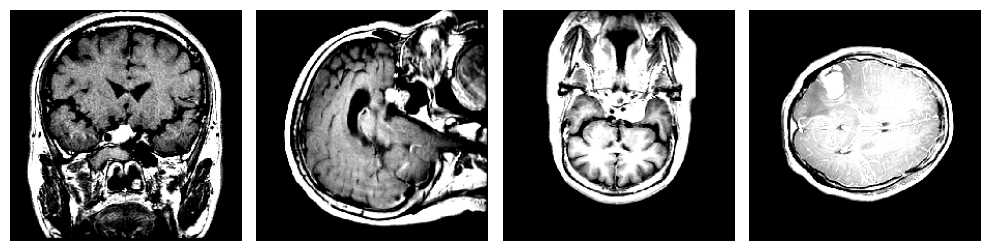

In [6]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(4)]
fig, axes = plt.subplots(1, 4, figsize = (10, 10))

#axes = axes.flatten()

for img, ax in zip(images, axes):
    #ax.imshow((img.reshape(image_size, image_size, 3)*255).astype("uint8"))
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Building the model

## ViT B16 model

In [5]:
from vit_keras import vit

vit_model = vit.vit_b16(image_size=image_size,
                        activation='softmax',
                        pretrained=True,
                        include_top=False,
                        pretrained_top=False,
                        classes=n_classes)

## ViT Model Architecture

In [6]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(32, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(n_classes, activation='softmax')  # Adjusted for n_classes and softmax
], name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)         

## Training the Model

In [10]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

trainHistory = model.history #guardamos historia

Epoch 1/30
259/259 [==============================] - 165s 533ms/step - loss: 0.5246 - accuracy: 0.8240 - val_loss: 0.4371 - val_accuracy: 0.9167
Epoch 2/30
259/259 [==============================] - 135s 520ms/step - loss: 0.4336 - accuracy: 0.9221 - val_loss: 0.5104 - val_accuracy: 0.9167
Epoch 3/30
259/259 [==============================] - 146s 563ms/step - loss: 0.3981 - accuracy: 0.9574 - val_loss: 0.4108 - val_accuracy: 0.9716
Epoch 4/30
259/259 [==============================] - 154s 596ms/step - loss: 0.3865 - accuracy: 0.9637 - val_loss: 0.3902 - val_accuracy: 0.9697
Epoch 5/30
259/259 [==============================] - 162s 627ms/step - loss: 0.3796 - accuracy: 0.9700 - val_loss: 0.3984 - val_accuracy: 0.9697
Epoch 6/30
259/259 [==============================] - 171s 660ms/step - loss: 0.3750 - accuracy: 0.9681 - val_loss: 0.3751 - val_accuracy: 0.9659
Epoch 7/30
259/259 [==============================] - 180s 696ms/step - loss: 0.3803 - accuracy: 0.9676 - val_loss: 0.3683 -

## Salvar y carregar model

In [7]:
import pickle
from keras.models import load_model

def save_trained_model(fileName, theModel, theHistory):
    # Check if the file already exists
    if not os.path.exists(fileName + '.h5'):
        # Save the model
        theModel.save(fileName + '.h5')

        # Save the history using pickle
        if isinstance(theHistory, tf.keras.callbacks.History):
            # If theHistory is a History object from model.fit --> 1st training
            history_dict = {
                'loss': theHistory.history['loss'],
                'accuracy': theHistory.history['accuracy'],
                'val_loss': theHistory.history['val_loss'],
                'val_accuracy': theHistory.history['val_accuracy'],
            }
        else:
            # If theHistory is a manually created dictionary --> additional trainings
            history_dict = theHistory

        with open(fileName + '_history.pkl', 'wb') as file:
            pickle.dump(history_dict, file)

        print("Model and history saved successfully.")
    else:
        print("The file already exists. No saving will be done.")   
        
def load_trained_model(fileName):
    
    # Provide the custom object when loading the model

    model = load_model(fileName+'.h5', custom_objects={'vit_model': vit_model})
    #model = load_model(fileName+'.h5', custom_objects={'vit_model': vit.vit_b16})

    # Load the training history using pickle
    historyFile = fileName + '_history.pkl'
    if os.path.exists(historyFile):
        with open(historyFile, 'rb') as file:
            trainHistory = pickle.load(file)
        print("Model and trainHistory loaded successfully.")
    else:
        trainHistory = None
        print("History file not found.")

    return model, trainHistory



In [12]:
save_trained_model('ViT_model', model, trainHistory)

Model and history saved successfully.


## Carregar model 

In [8]:
loaded_model, previous_history = load_trained_model('ViT_model')

Model and trainHistory loaded successfully.


## Nou entrenament (opcional)

In [23]:
"""
additional_epochs = 5
learning_rate = 1e-4 
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate) 
loaded_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

new_history= loaded_model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = additional_epochs,
          callbacks = early_stopping_callbacks)
        
 """       

Epoch 1/5
207/207 [==============================] - 131s 513ms/step - loss: 0.3509 - accuracy: 0.9849 - val_loss: 0.3276 - val_accuracy: 1.0000
Epoch 2/5
207/207 [==============================] - 96s 463ms/step - loss: 0.3505 - accuracy: 0.9831 - val_loss: 0.3272 - val_accuracy: 1.0000
Epoch 3/5
207/207 [==============================] - 101s 490ms/step - loss: 0.3556 - accuracy: 0.9800 - val_loss: 0.3700 - val_accuracy: 0.9615
Epoch 4/5
207/207 [==============================] - 109s 525ms/step - loss: 0.3555 - accuracy: 0.9812 - val_loss: 0.3419 - val_accuracy: 0.9904
Epoch 5/5
207/207 [==============================] - 114s 551ms/step - loss: 0.3550 - accuracy: 0.9794 - val_loss: 0.3525 - val_accuracy: 0.9808


In [24]:
#save_trained_model('ViT_model', loaded_model, new_history)

Model and history saved successfully.


In [26]:
#loaded_model, new_history = load_trained_model('ViT_model')

Model and trainHistory loaded successfully.


In [27]:
#new_history['loss']

[0.35086649656295776,
 0.3505123555660248,
 0.3555724620819092,
 0.3555092513561249,
 0.35502076148986816]

In [28]:
# Concatenate all keys in the training history
"""
combined_history = {}
for key in previous_history.keys():
    combined_history[key] = previous_history[key] + new_history[key]
"""

In [29]:
#save_trained_model('ViT_model', loaded_model, combined_history)

Model and history saved successfully.


## Graficar historia

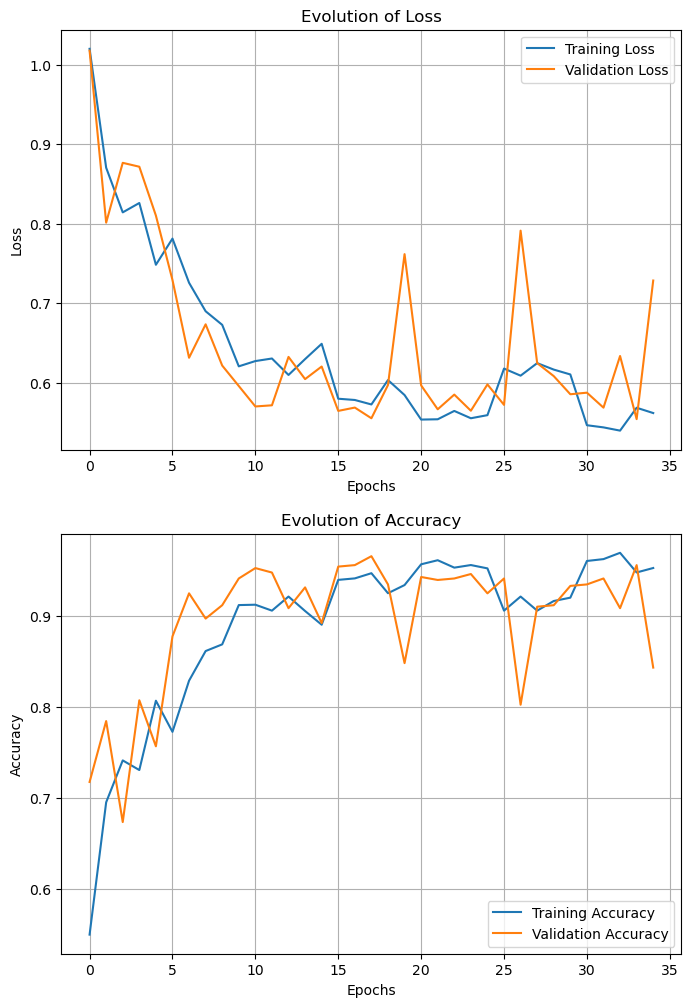

In [9]:
def plot_history(theHistory):
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))
    
    # Create the first subplot for the evolution of training and validation loss
    ax[0].plot(theHistory['loss'], label='Training Loss')
    ax[0].plot(theHistory['val_loss'], label='Validation Loss')
    ax[0].set_title('Evolution of Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)
    
    # Create the second subplot for the evolution of training and validation accuracy
    ax[1].plot(theHistory['accuracy'], label='Training Accuracy')
    ax[1].plot(theHistory['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Evolution of Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()


plot_history(previous_history)


## Resultats

154/154 [==============================] - 26s 128ms/step
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       141
           1       1.00      0.75      0.86       285
           2       0.75      0.89      0.81       186

    accuracy                           0.84       612
   macro avg       0.84      0.87      0.84       612
weighted avg       0.87      0.84      0.85       612



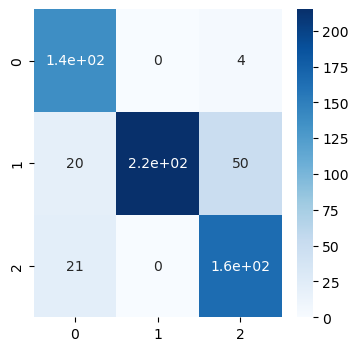

In [13]:
predicted_classes = np.argmax(loaded_model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (4, 4))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

## Inferencia

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image file
img_path = 'brain-tumor_dataset/clase_1/image_36.png' 
#img_path = 'brain-tumor_dataset/clase_2/image_567.png' #
img = image.load_img(img_path, target_size=(224, 224))  # Replace with your model's input size

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Assuming your model expects images in [0, 1]

# Make prediction
predictions = loaded_model.predict(img_array)

# Interpret prediction
predicted_class = np.argmax(predictions, axis=1)
predicted_class_label = class_labels[predicted_class[0]]

print("Predicted class:", predicted_class_label)

1/1 [==============================] - 3s 3s/step
Predicted class: clase_3


## Mapa d'atenció

1/1 [==============================] - 2s 2s/step


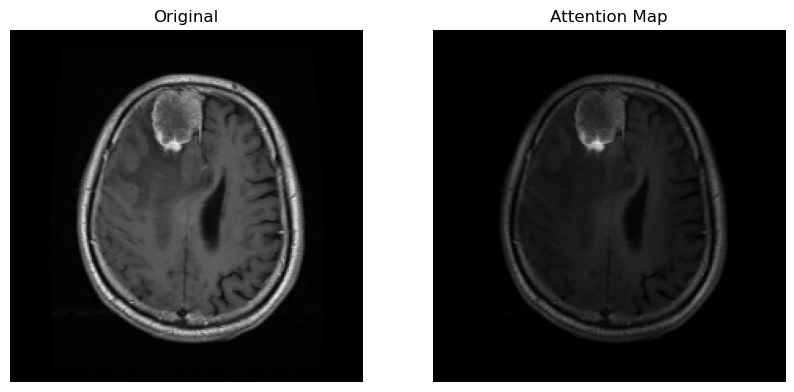

In [16]:
from vit_keras import utils, visualize

# Load the image file
img =utils.read(img_path, 224)

#Generate the attention map
attention_map = visualize.attention_map(model=vit_model, image=img)


# Plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,10))
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
ax1.imshow(img)
ax2.imshow(attention_map)


## Visualitzar 10 imatges classificades correctament i grad-cam

1/1 [==============================] - 2s 2s/step


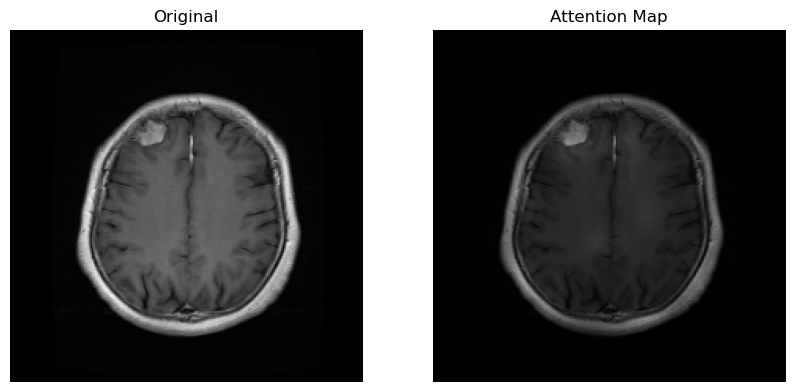

1/1 [==============================] - 3s 3s/step


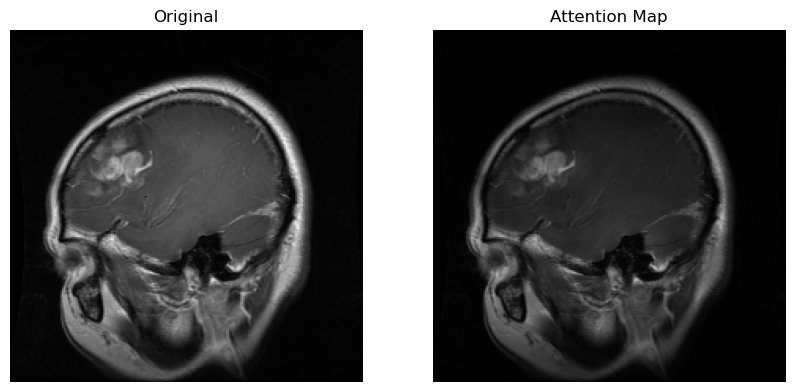

1/1 [==============================] - 2s 2s/step


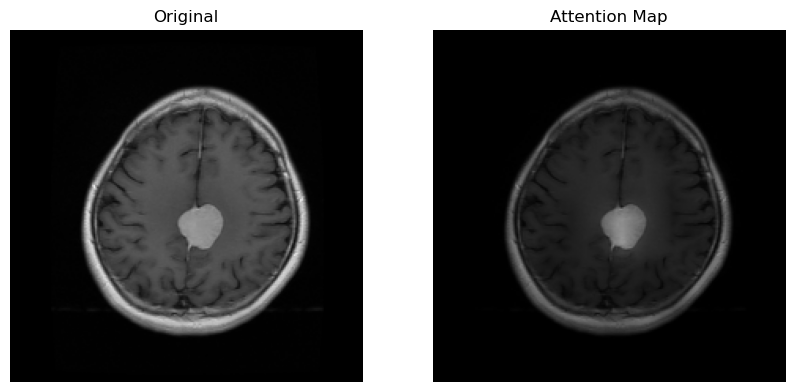

1/1 [==============================] - 2s 2s/step


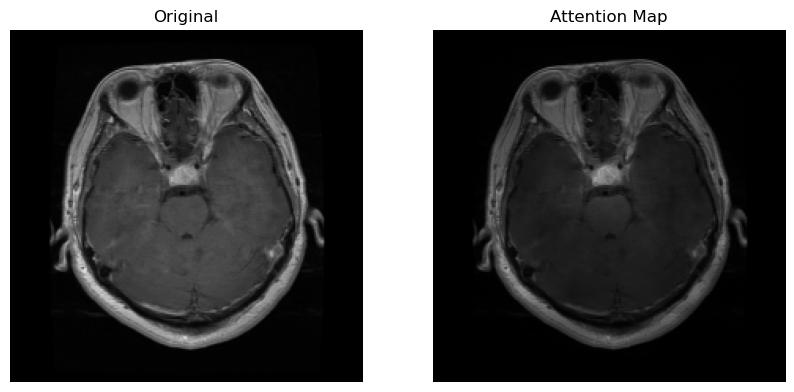

1/1 [==============================] - 2s 2s/step


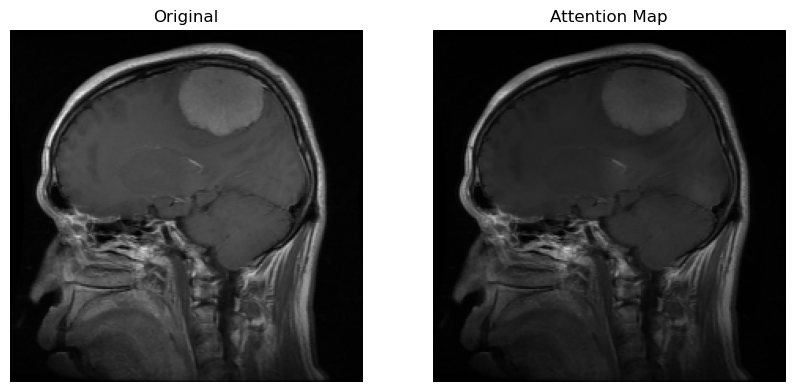

1/1 [==============================] - 3s 3s/step


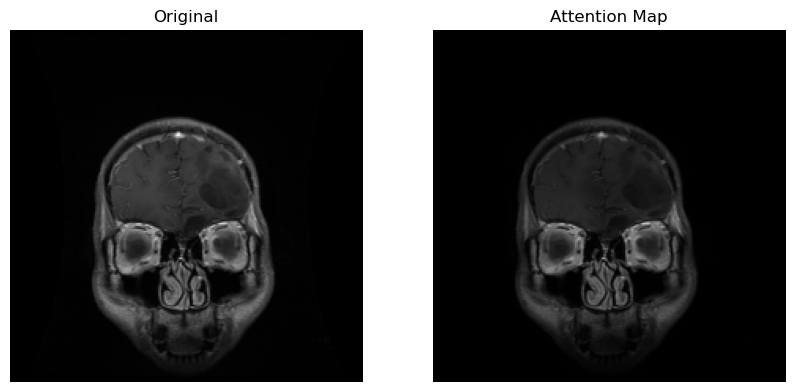

1/1 [==============================] - 2s 2s/step


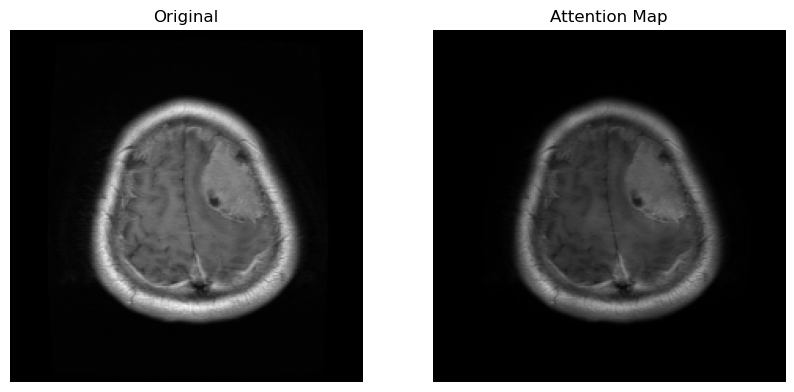

1/1 [==============================] - 2s 2s/step


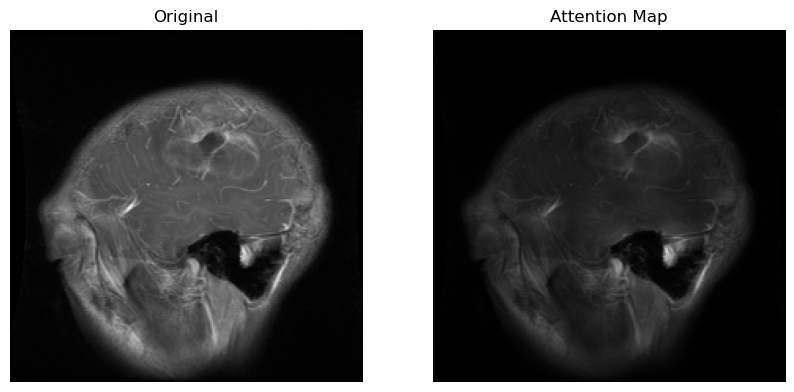

1/1 [==============================] - 2s 2s/step


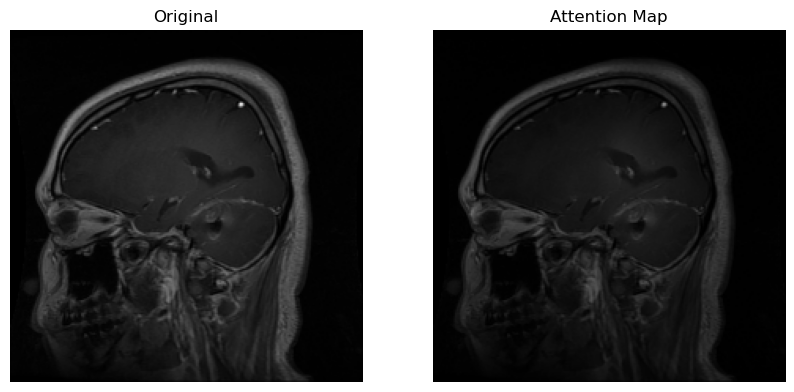

1/1 [==============================] - 2s 2s/step


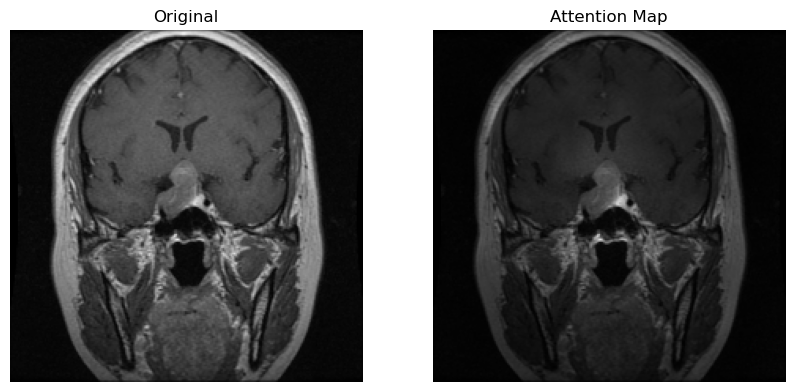

In [18]:
#Elements de Classe 0 (Meningioma) classificats erròniament
predictions = loaded_model.predict(valid_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_gen.classes
filenames = valid_gen.filenames

# Trobar els indexs dels elements classificats correctament
correct_classification_indices = [i for i, (true, pred) in enumerate(zip(true_classes, predicted_classes)) if (true == 0 and pred == 0) or (true==1 and pred==1) or (true==2 and pred==2)]

#seleccionar 10 indexs random
random_indices = np.random.choice(correct_classification_indices, 10, replace=False)

# Trobar els noms dels arxius
correct_class_filenames = [filenames[i] for i in random_indices]

for filename in correct_class_filenames:
    img_path = os.path.join(train_path, filename)
    img = utils.read(img_path, image_size)

    # Generate attention map
    attention_map = visualize.attention_map(model=vit_model, image=img)

    # Plot the original image and attention map
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(attention_map)
    ax2.set_title('Attention Map')
    ax2.axis('off')
    
    plt.show()
#print(count, ' elements')

## Visualitzar 10 imatges classificades incorrectament i grad-cam

1/1 [==============================] - 3s 3s/step


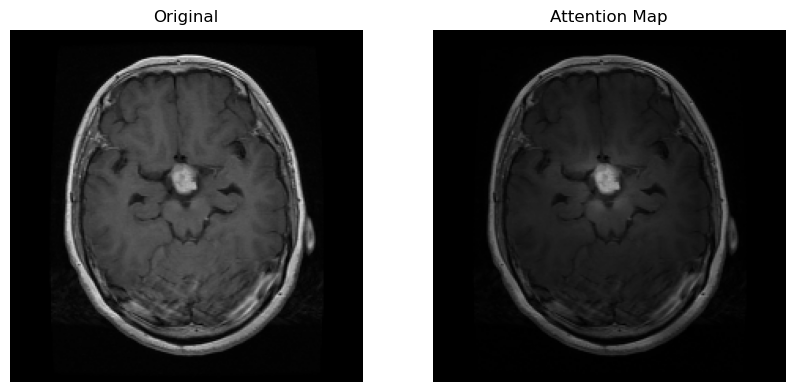

1/1 [==============================] - 2s 2s/step


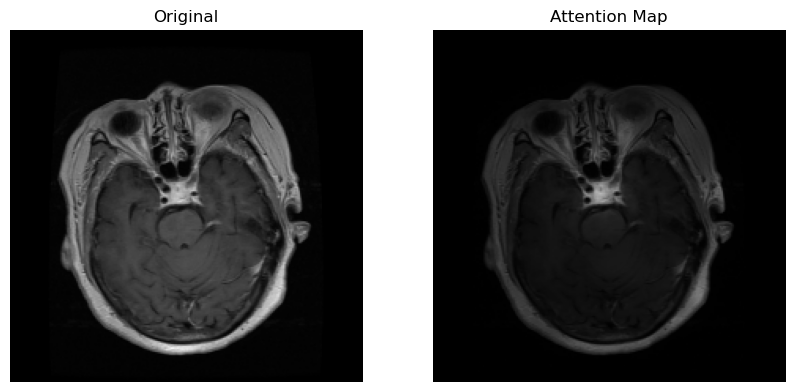

1/1 [==============================] - 2s 2s/step


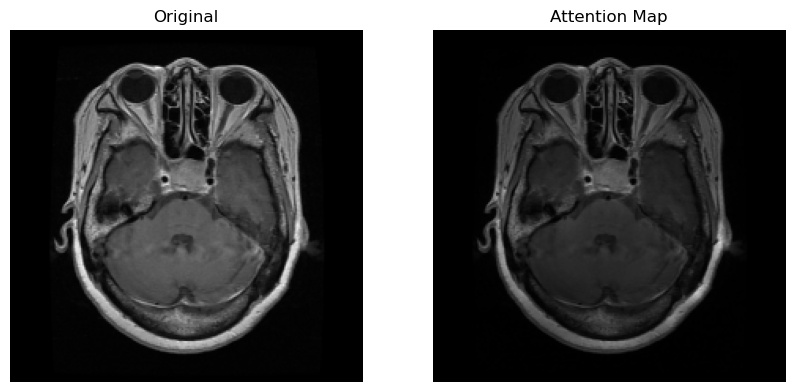

1/1 [==============================] - 2s 2s/step


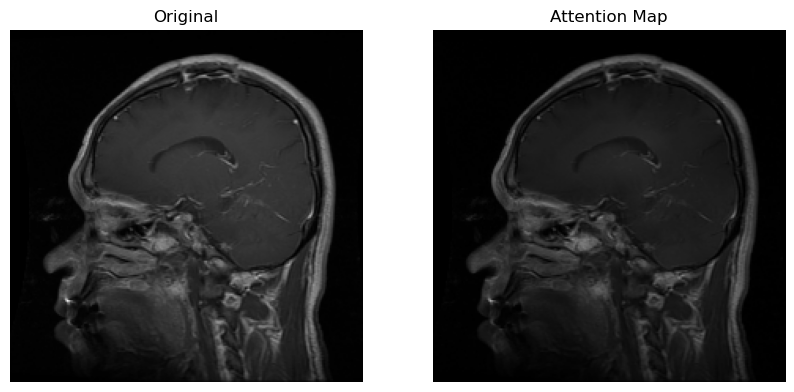

1/1 [==============================] - 3s 3s/step


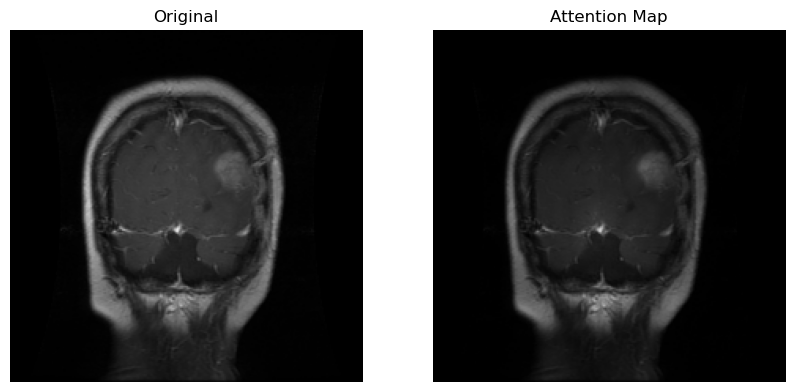

1/1 [==============================] - 3s 3s/step


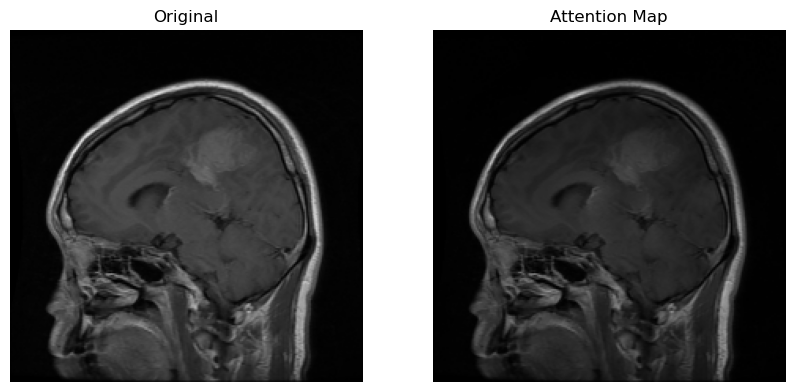

1/1 [==============================] - 2s 2s/step


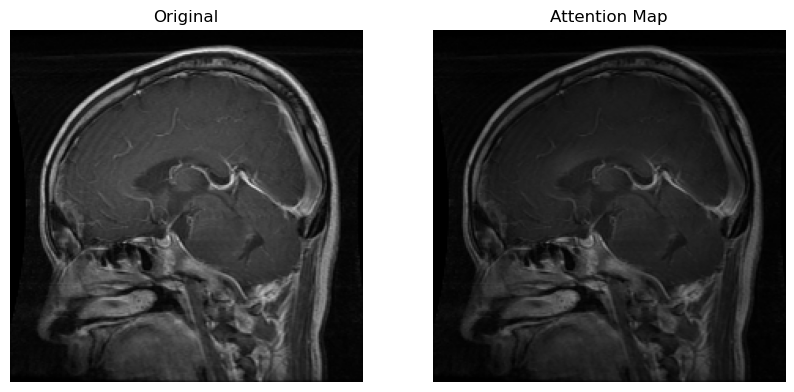

1/1 [==============================] - 2s 2s/step


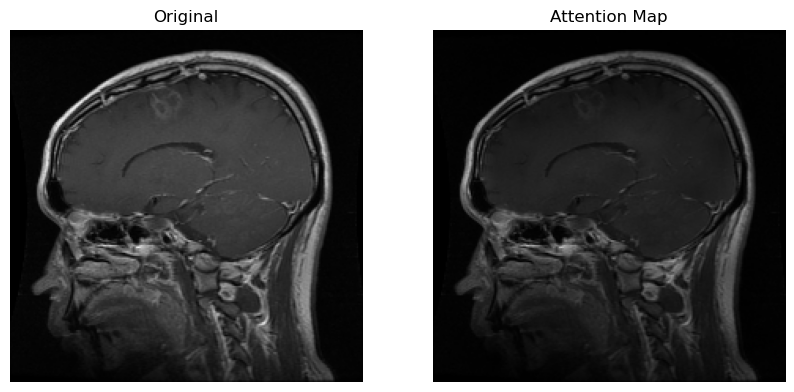

1/1 [==============================] - 2s 2s/step


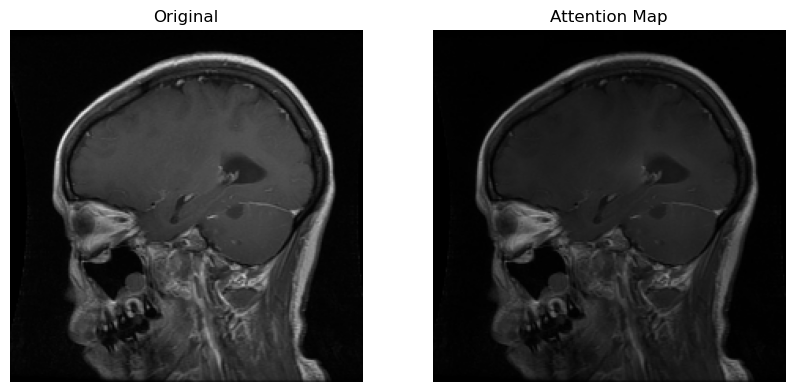

1/1 [==============================] - 2s 2s/step


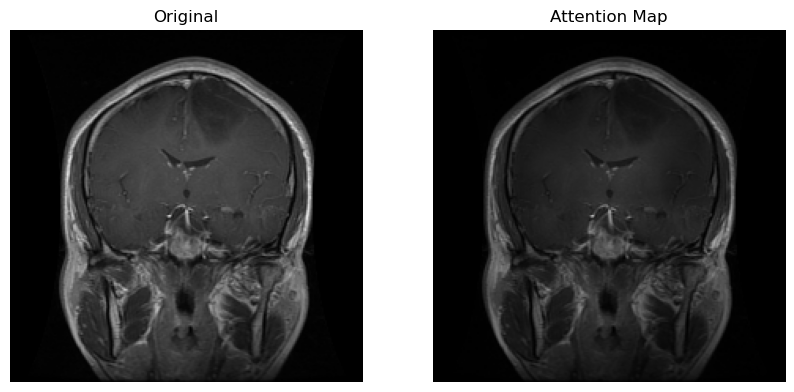

In [19]:
#Elements de Classe 2 (Pituitaria Tumor) classificats erròniament
predictions = loaded_model.predict(valid_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_gen.classes
filenames = valid_gen.filenames

# Trobar els indexs dels elements classificats erròniament
incorrect_classification_indices = [i for i, (true, pred) in enumerate(zip(true_classes, predicted_classes)) if (true == 0 and pred != 0) or (true==1 and pred!=1) or (true==2 and pred!=2)]
#seleccionar 10 indexs random
random_indices = np.random.choice(incorrect_classification_indices, 10, replace=False)

# Trobar el nom dels arxius
incorrect_class_filenames = [filenames[i] for i in random_indices]

for filename in incorrect_class_filenames:
    img_path = os.path.join(train_path, filename)
    img = utils.read(img_path, image_size)

    # Generate attention map
    attention_map = visualize.attention_map(model=vit_model, image=img)

    # Plot the original image and attention map
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(attention_map)
    ax2.set_title('Attention Map')
    ax2.axis('off')
    
    plt.show()
